<a href="https://colab.research.google.com/github/rizalagussaini/telco_churn_app/blob/main/Salinan_dari_6_churn_Pengembangan_Rizal_Tanpa_Catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightgbm

# EDA

In [2]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the data file
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Churn
No     5174
Yes    1869
Name: count, dtype: int64


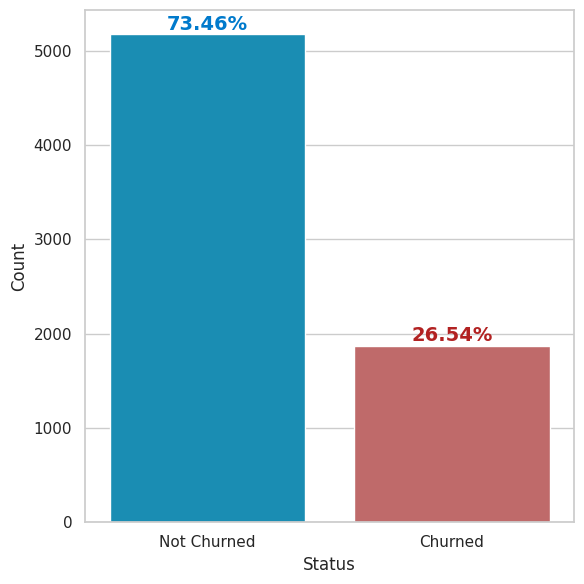

In [5]:
# Hitung jumlah dan persentase
print(df['Churn'].value_counts())

count = df['Churn'].value_counts()
percent = df['Churn'].value_counts(normalize=True) * 100

labels = ['Not Churned' if val == 'No' else 'Churned' for val in count.index]

plt.figure(figsize=(6, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=labels, y=count.values, hue=labels, palette=['#009ACD', '#CD5C5C'], legend=False)

for i, p in enumerate(count.values):
    percentage = f"{percent.iloc[i]:.2f}%"
    color = '#007ACC' if labels[i] == 'Not Churned' else '#B22222'
    plt.text(i, p + 50, percentage, ha='center', color=color, fontsize=14, fontweight='bold')

plt.xlabel('Status')
plt.ylabel('Count')
plt.title('')
plt.tight_layout()
plt.show()

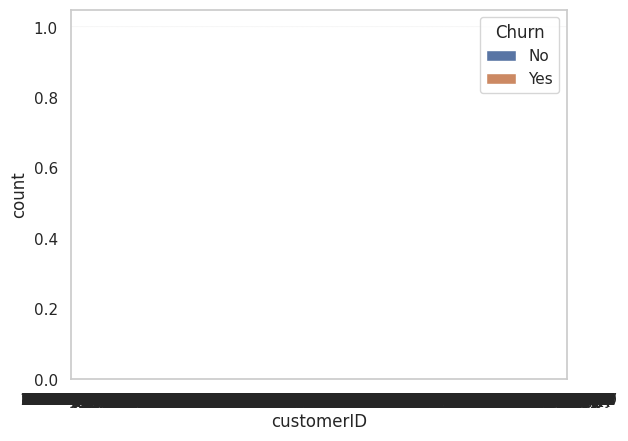

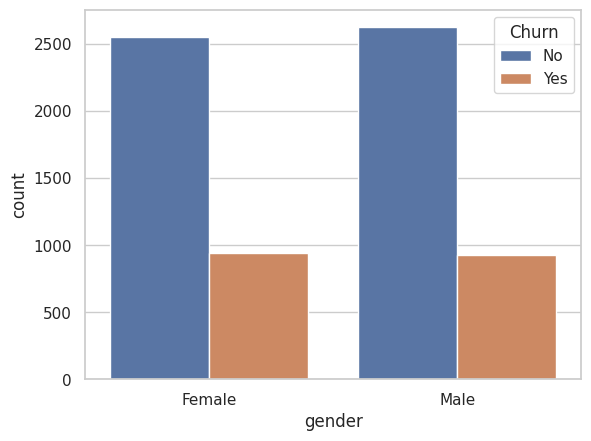

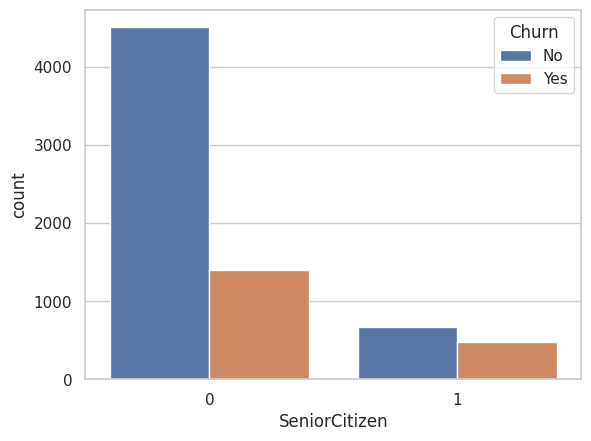

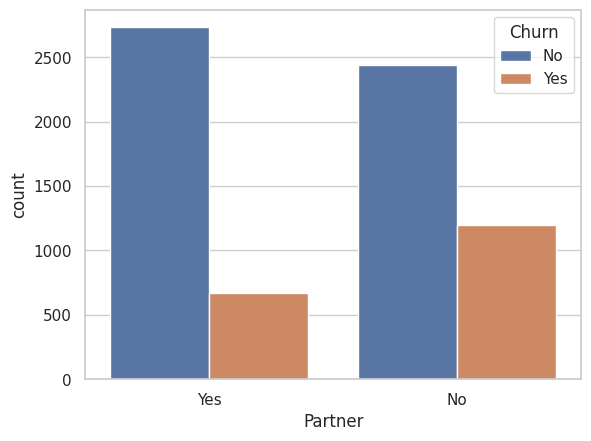

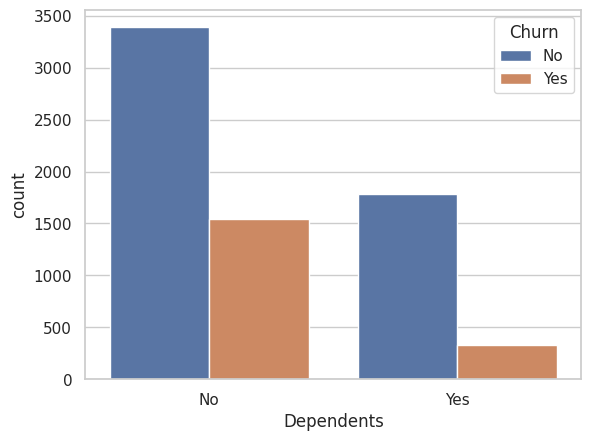

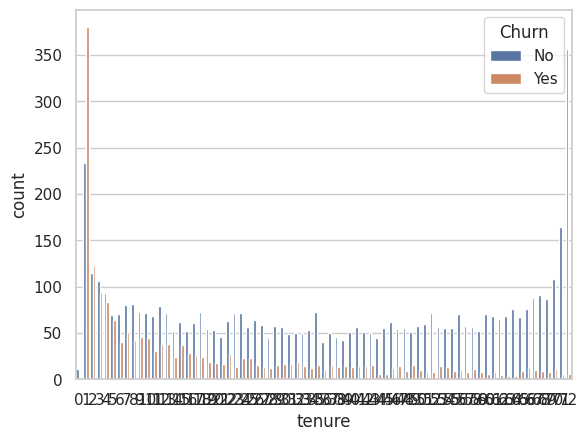

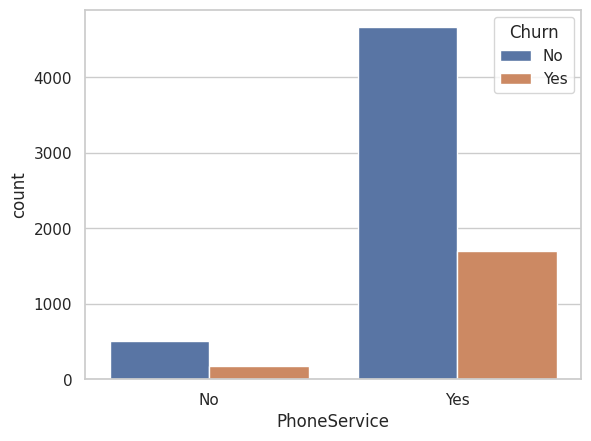

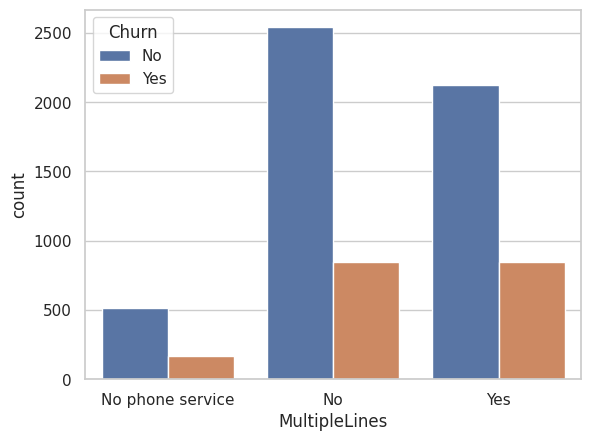

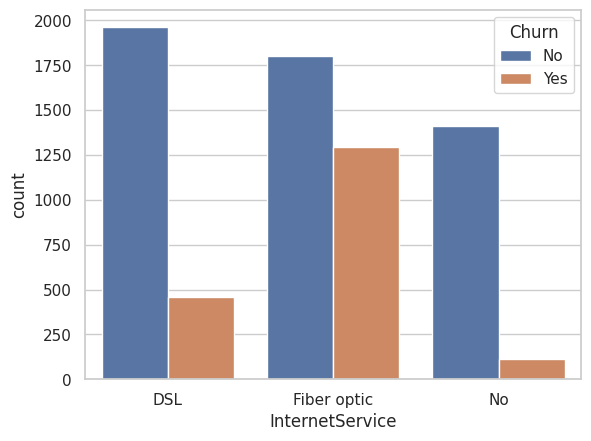

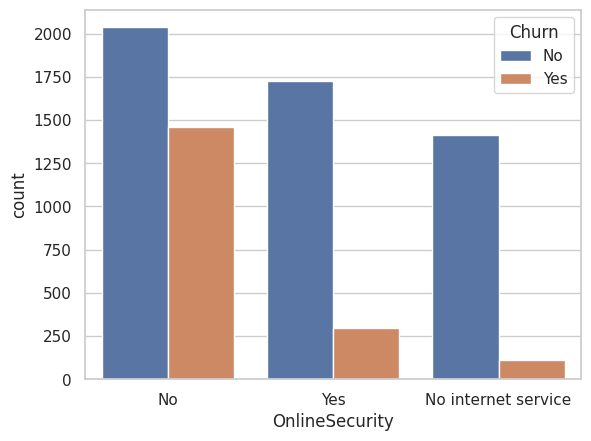

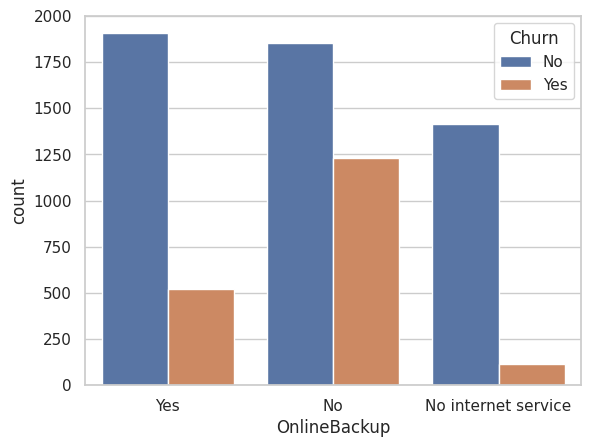

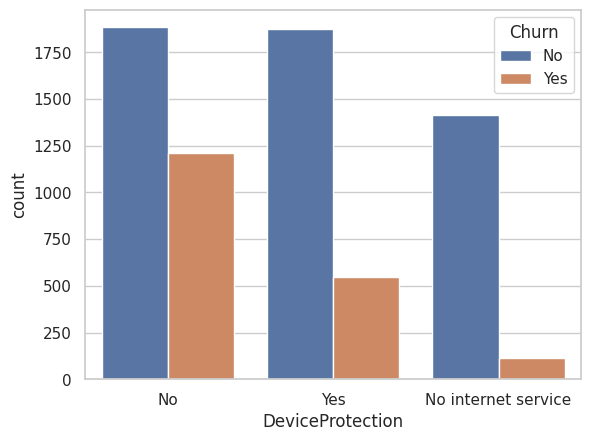

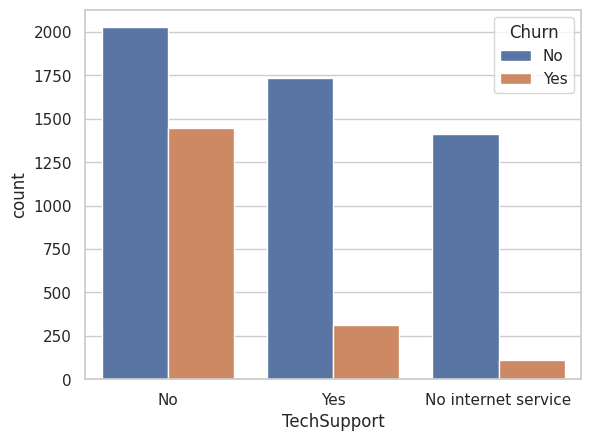

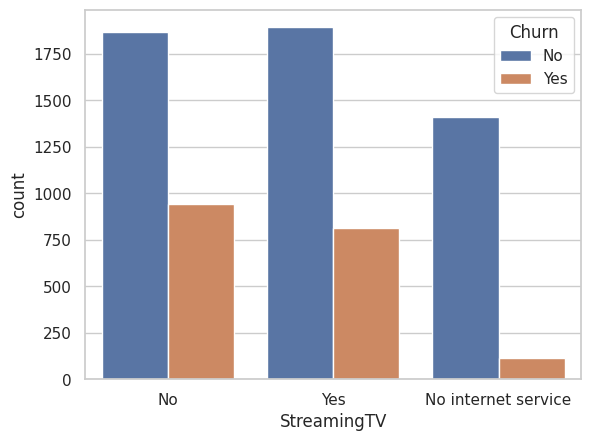

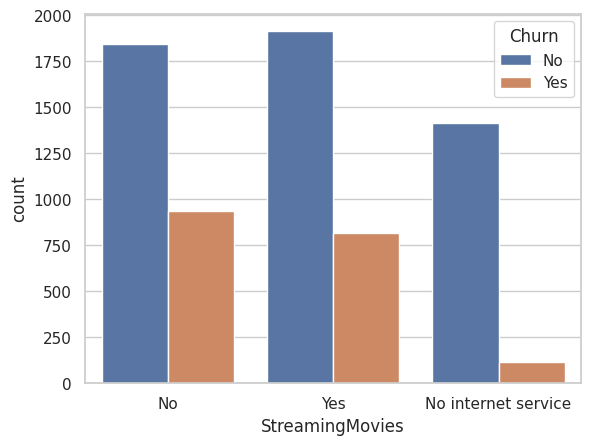

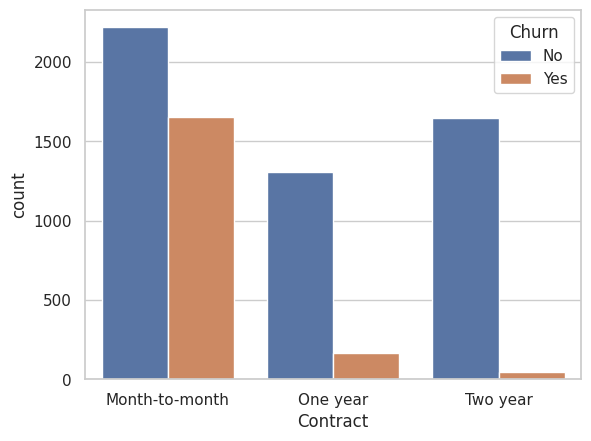

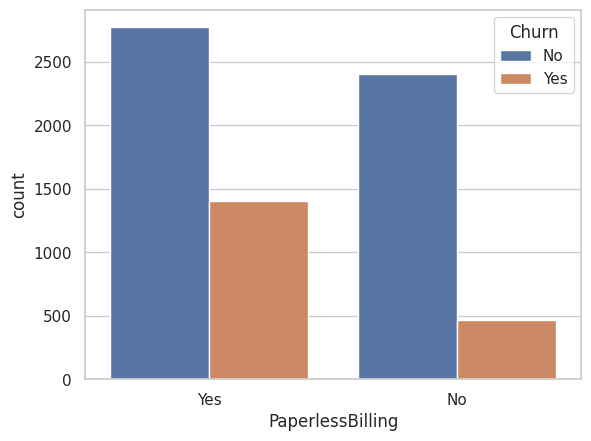

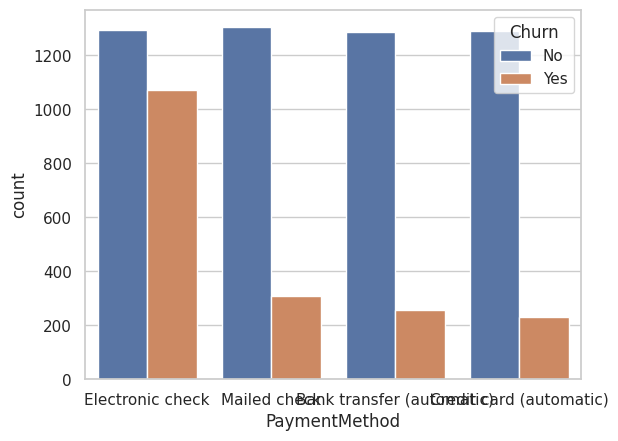

In [6]:
# Distribusi dari setiap fitur dengan Churn.
for i, predictor in enumerate(df.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges'])):
    plt.figure(i)
    sns.countplot(data=df, x=predictor, hue='Churn')

# Preprocessing

In [7]:
# Create a copy of base data for manupulation & processing
telco_data = df.copy()

In [8]:
# Encode 'TotalCharges' and 'Churn'
telco_data['TotalCharges'] = pd.to_numeric(telco_data['TotalCharges'], errors='coerce')
telco_data['Churn'] = telco_data['Churn'].map({'Yes': 1, 'No': 0})

In [9]:
# check missing values
telco_data.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [10]:
# handling 'TotalCharges' missing values
telco_data.dropna(how='any', inplace=True)

In [11]:
# drop irrelevant columns
telco_data.drop(columns=['customerID'], inplace=True)

In [12]:
# Pengembangan dari Rizal
# Fitur baru: Rata-rata Pembayaran per Bulan
# Hindari pembagian dengan nol
telco_data = telco_data[telco_data['tenure'] != 0]
telco_data['AvgMonthlyPayment'] = telco_data['TotalCharges'] / telco_data['tenure']


In [13]:
# Pengembangan dari Rizal
# Fitur Interaksi: InternetService x Contract
telco_data['Internet_Contract'] = telco_data['InternetService'] + "_" + telco_data['Contract']


In [14]:
# check 'tenure' max value
print(telco_data['tenure'].max())

72


In [15]:
# making a gorup of tenure in range of 12 months each
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]
telco_data['tenure_group'] = pd.cut(telco_data.tenure, range(1, 80, 12), right=False, labels=labels)

In [16]:
telco_data['tenure_group'].value_counts()

,count
tenure_group,
1 - 12,2175
61 - 72,1407
13 - 24,1024
25 - 36,832
49 - 60,832
37 - 48,762


In [17]:
# Pengembangan dari Rizal
# Deteksi dan Penanganan Outlier (IQR Method)
# Deteksi outlier untuk 'MonthlyCharges' dan 'TotalCharges'
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

# Terapkan ke dua kolom
telco_data = remove_outliers_iqr(telco_data, 'MonthlyCharges')
telco_data = remove_outliers_iqr(telco_data, 'TotalCharges')


In [18]:
# encode all categorical columns
telco_data_dummies = pd.get_dummies(telco_data)
telco_data_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,AvgMonthlyPayment,gender_Female,gender_Male,Partner_No,Partner_Yes,...,Internet_Contract_Fiber optic_Two year,Internet_Contract_No_Month-to-month,Internet_Contract_No_One year,Internet_Contract_No_Two year,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,1,29.85,29.85,0,29.850000,True,False,False,True,...,False,False,False,False,True,False,False,False,False,False
1,0,34,56.95,1889.50,0,55.573529,False,True,True,False,...,False,False,False,False,False,False,True,False,False,False
2,0,2,53.85,108.15,1,54.075000,False,True,True,False,...,False,False,False,False,True,False,False,False,False,False
3,0,45,42.30,1840.75,0,40.905556,False,True,True,False,...,False,False,False,False,False,False,False,True,False,False
4,0,2,70.70,151.65,1,75.825000,True,False,True,False,...,False,False,False,False,True,False,False,False,False,False


In [19]:
telco_data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 62 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   SeniorCitizen                                 7032 non-null   int64  
 1   tenure                                        7032 non-null   int64  
 2   MonthlyCharges                                7032 non-null   float64
 3   TotalCharges                                  7032 non-null   float64
 4   Churn                                         7032 non-null   int64  
 5   AvgMonthlyPayment                             7032 non-null   float64
 6   gender_Female                                 7032 non-null   bool   
 7   gender_Male                                   7032 non-null   bool   
 8   Partner_No                                    7032 non-null   bool   
 9   Partner_Yes                                   7032 non-null   bool  

In [20]:
# convert all bool columns to numeric
bool_cols = telco_data_dummies.select_dtypes(include='bool').columns
telco_data_dummies[bool_cols] = telco_data_dummies[bool_cols].astype(int)

In [21]:
telco_data_dummies

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,AvgMonthlyPayment,gender_Female,gender_Male,Partner_No,Partner_Yes,...,Internet_Contract_Fiber optic_Two year,Internet_Contract_No_Month-to-month,Internet_Contract_No_One year,Internet_Contract_No_Two year,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,1,29.85,29.85,0,29.850000,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,34,56.95,1889.50,0,55.573529,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,2,53.85,108.15,1,54.075000,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
3,0,45,42.30,1840.75,0,40.905556,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,2,70.70,151.65,1,75.825000,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1990.50,0,82.937500,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
7039,0,72,103.20,7362.90,0,102.262500,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
7040,0,11,29.60,346.45,0,31.495455,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
7041,1,4,74.40,306.60,1,76.650000,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0


<Axes: >

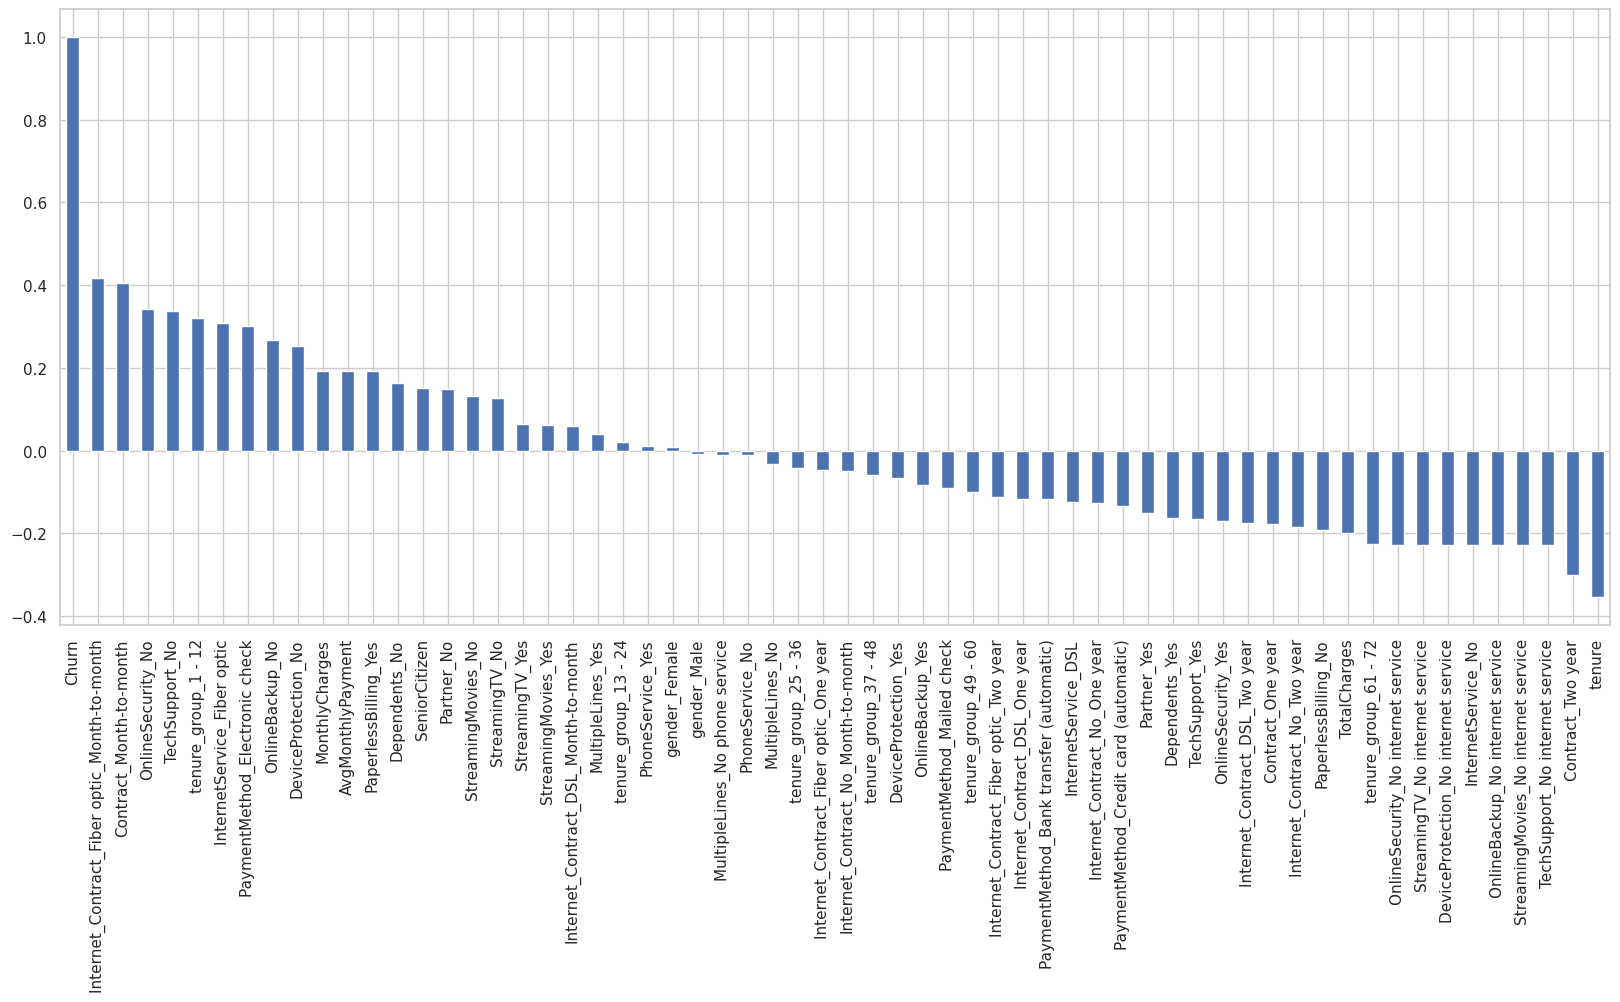

In [22]:
# Check features correlation with 'Churn'
plt.figure(figsize=(20,8))
telco_data_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

In [23]:
# drop irrelevant columns based on correlation result
telco_data_dummies.drop(columns=['gender_Male', 'gender_Female', 'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No', 'MultipleLines_Yes', 'MultipleLines_No phone service'], inplace=True)

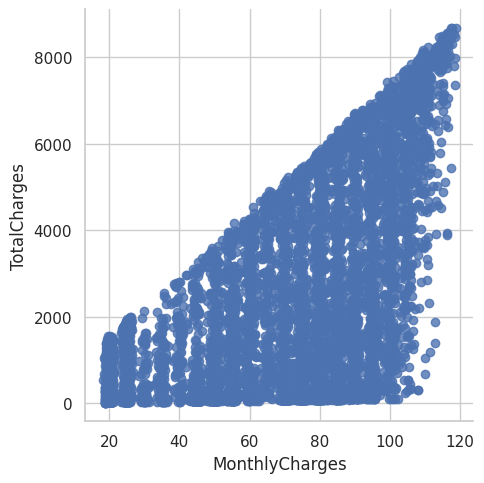

In [24]:
# Relationship between Monthly Charges and Total Charges
sns.lmplot(data=telco_data_dummies, x='MonthlyCharges', y='TotalCharges', fit_reg=False)

Text(0.5, 1.0, 'TotalCharges by churn')

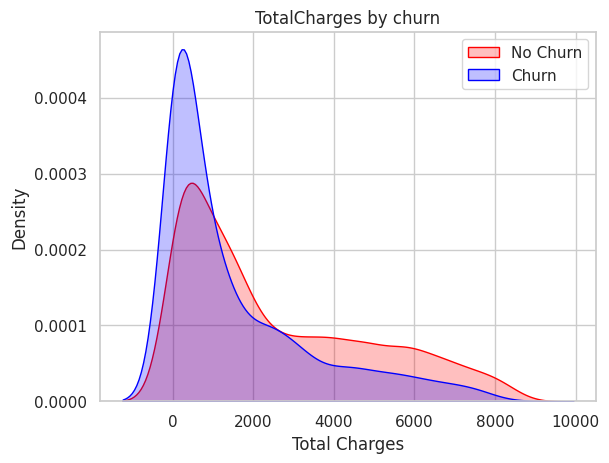

In [25]:
Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 0)], color="Red", fill=True)
Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 1)], ax=Tot, color="Blue", fill=True)

Tot.legend(["No Churn", "Churn"], loc='upper right')
Tot.set_ylabel('Density')
Tot.set_xlabel('Total Charges')
Tot.set_title('TotalCharges by churn')

In [26]:
telco_data_dummies.to_csv('tel_churn.csv')

In [27]:
# Import metrics evaluation from scikit-learn
from sklearn.model_selection import train_test_split

# handling imbalance
from imblearn.combine import SMOTEENN

In [28]:
# load dataset
df = pd.read_csv("tel_churn.csv")
df

,Unnamed: 0,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,AvgMonthlyPayment,Partner_No,Partner_Yes,Dependents_No,...,Internet_Contract_Fiber optic_Two year,Internet_Contract_No_Month-to-month,Internet_Contract_No_One year,Internet_Contract_No_Two year,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,0,1,29.85,29.85,0,29.850000,0,1,1,...,0,0,0,0,1,0,0,0,0,0
1,1,0,34,56.95,1889.50,0,55.573529,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,2,0,2,53.85,108.15,1,54.075000,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,3,0,45,42.30,1840.75,0,40.905556,1,0,1,...,0,0,0,0,0,0,0,1,0,0
4,4,0,2,70.70,151.65,1,75.825000,1,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,7038,0,24,84.80,1990.50,0,82.937500,0,1,0,...,0,0,0,0,0,1,0,0,0,0
7028,7039,0,72,103.20,7362.90,0,102.262500,0,1,0,...,0,0,0,0,0,0,0,0,0,1
7029,7040,0,11,29.60,346.45,0,31.495455,0,1,0,...,0,0,0,0,1,0,0,0,0,0
7030,7041,1,4,74.40,306.60,1,76.650000,0,1,1,...,0,0,0,0,1,0,0,0,0,0


In [29]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [30]:
# delete 'Churn' from the dataset and set it as a target column
x = df.drop('Churn', axis=1)
y = df['Churn']

In [31]:
# dataset test train split (80:20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [32]:
# handling class imbalance with SMOTEENN
sm = SMOTEENN(random_state=42)
x_resampled, y_resampled = sm.fit_resample(x_train, y_train)

In [33]:
print("Before SMOTEENN:", y_train.value_counts())
print("After SMOTEENN:", y_resampled.value_counts())

Before SMOTEENN: Churn
0    4130
1    1495
Name: count, dtype: int64
After SMOTEENN: Churn
1    2513
0    2154
Name: count, dtype: int64


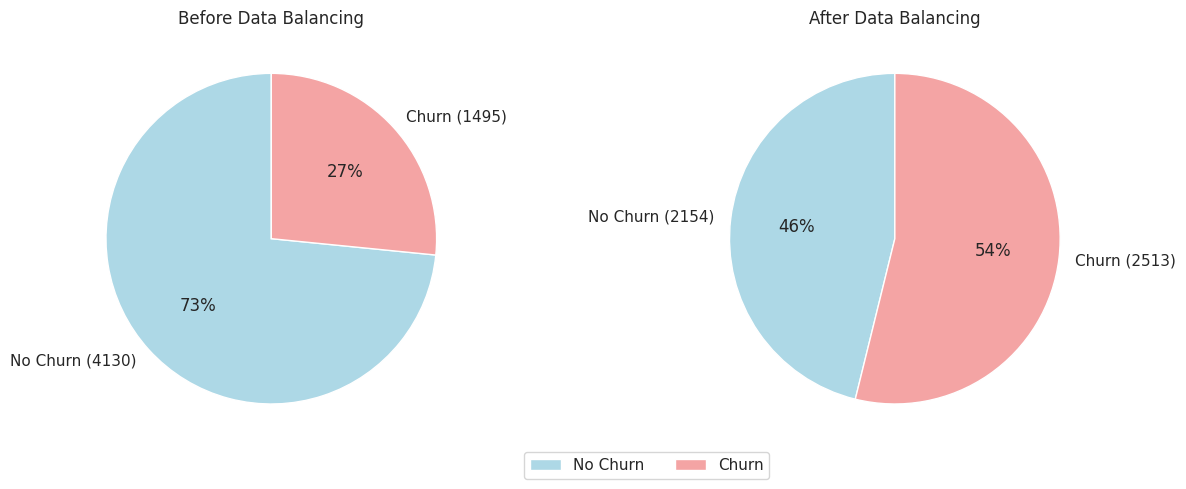

In [34]:
before_counts = y_train.value_counts().sort_index()
after_counts = y_resampled.value_counts().sort_index()

# Label dan warna berdasarkan urutan yang benar (misal No = 0, Yes = 1)
labels = ['No Churn', 'Churn']
colors = ['#ADD8E6', '#F4A4A4']  # biru muda dan peach

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart before balancing
axes[0].pie(
    before_counts,
    labels=[f'{labels[i]} ({before_counts.iloc[i]})' for i in range(2)],
    colors=colors,
    autopct='%1.0f%%',
    startangle=90
)
axes[0].set_title('Before Data Balancing')

# Pie chart after balancing
axes[1].pie(
    after_counts,
    labels=[f'{labels[i]} ({after_counts.iloc[i]})' for i in range(2)],
    colors=colors,
    autopct='%1.0f%%',
    startangle=90
)
axes[1].set_title('After Data Balancing')

plt.legend(labels, loc='lower center', bbox_to_anchor=(-0.1, -0.1), ncol=2)
plt.tight_layout()
plt.show()

# Model Training

In [35]:
# Import matrix library
from sklearn import metrics # Import the metrics module
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Import model Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## DesicionTreeClssifier

In [36]:
from sklearn.model_selection import GridSearchCV # Hyperparameter Tuning DesicionTreeClassifier
from sklearn import metrics

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 6, 8, 10, None],
    'min_samples_leaf': [1, 4, 8, 10, 20],
    'min_samples_split': [2, 5, 10]
}

dt = DecisionTreeClassifier(random_state=100)

grid_search = GridSearchCV(estimator=dt,
                           param_grid=param_grid,
                           cv=5,
                           scoring='recall',  # Atau 'accuracy', 'f1', tergantung tujuanmu
                           n_jobs=-1)

grid_search.fit(x_resampled, y_resampled)

best_dt = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluasi pada data uji
y_pred = best_dt.predict(x_test)
print("Model Score:", best_dt.score(x_test, y_test), "\n")
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred), "\n")
print("Classification Report:")
print(metrics.classification_report(y_test, y_pred), "\n")

Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
Model Score: 0.7491115849324804 

Confusion Matrix:
[[777 256]
 [ 97 277]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1033
           1       0.52      0.74      0.61       374

    accuracy                           0.75      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.79      0.75      0.76      1407
 



In [37]:
model_dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=8,
    min_samples_leaf=1,
    min_samples_split=2
)

# Train dt model with the resampled data train
model_dt.fit(x_resampled, y_resampled)

# Memprediksi hasil menggunakan model yang telah dilatih
yr_dt_pred = model_dt.predict(x_test)

# Mengukur akurasi model terhadap data uji
model_score_dt = model_dt.score(x_test, y_test)

# Menampilkan skor akurasi model
print("Model Score:", model_score_dt, "\n")

# Menampilkan confusion matrix untuk membandingkan hasil prediksi dengan label sebenarnya
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, yr_dt_pred), "\n")

# Menampilkan laporan klasifikasi untuk melihat metrik evaluasi seperti precision, recall, dan f1-score
print("Classification Report:")
print(metrics.classification_report(y_test, yr_dt_pred), "\n")

Model Score: 0.7505330490405118 

Confusion Matrix:
[[779 254]
 [ 97 277]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.82      1033
           1       0.52      0.74      0.61       374

    accuracy                           0.75      1407
   macro avg       0.71      0.75      0.71      1407
weighted avg       0.79      0.75      0.76      1407
 



## RandomForestClassifier

In [38]:
from sklearn.model_selection import GridSearchCV # Hyperparameter tuning RandomForestClassifier

# Definisikan parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8, 10, None],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

# Buat model dasar
rf = RandomForestClassifier(random_state=100)

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                           scoring='accuracy')

# Lakukan fitting
grid_search.fit(x_resampled, y_resampled)

# Tampilkan parameter terbaik
print("Best Parameters:", grid_search.best_params_)

# Gunakan model terbaik untuk prediksi
best_rf = grid_search.best_estimator_
yr_rf_pred = best_rf.predict(x_test)

# Evaluasi model
model_score_rf = best_rf.score(x_test, y_test)
print("Model Score:", model_score_rf, "\n")
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, yr_rf_pred), "\n")
print("Classification Report:")
print(metrics.classification_report(y_test, yr_rf_pred), "\n")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}
Model Score: 0.7448471926083866 

Confusion Matrix:
[[778 255]
 [104 270]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1033
           1       0.51      0.72      0.60       374

    accuracy                           0.74      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.78      0.74      0.76      1407
 



In [39]:
model_rf = RandomForestClassifier(
    n_estimators=200,
    criterion='entropy',
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1
)

# Melatih model Random Forest yang telah dibuat dengan data latih hasil resampling
model_rf.fit(x_resampled, y_resampled)

# Memprediksi hasil menggunakan model yang telah dilatih
yr_rf_pred = model_rf.predict(x_test)

# Mengukur akurasi model terhadap data uji
model_score_rf = model_rf.score(x_test, y_test)

# Menampilkan skor akurasi model
print("Model Score:", model_score_rf, "\n")

# Menampilkan confusion matrix untuk membandingkan hasil prediksi dengan label sebenarnya
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, yr_rf_pred), "\n")

# Menampilkan laporan klasifikasi untuk melihat metrik evaluasi seperti precision, recall, dan f1-score
print("Classification Report:")
print(metrics.classification_report(y_test, yr_rf_pred), "\n")

Model Score: 0.7555081734186212 

Confusion Matrix:
[[787 246]
 [ 98 276]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1033
           1       0.53      0.74      0.62       374

    accuracy                           0.76      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.76      0.77      1407
 



## XGBoost

In [40]:
from xgboost import XGBClassifier # Hyperparameter tuning XGBoost
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 0.1, 0.5],
}

xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=100,
    use_label_encoder=False,
    eval_metric='logloss'  # Tambahan agar tidak muncul warning
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='recall',  # Ganti dengan 'f1', 'roc_auc', atau 'accuracy' sesuai kebutuhan
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(x_resampled, y_resampled)
best_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluasi di data uji
yr_xgb_pred = best_xgb.predict(x_test)

print("Model Score:", best_xgb.score(x_test, y_test), "\n")
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, yr_xgb_pred), "\n")
print("Classification Report:")
print(metrics.classification_report(y_test, yr_xgb_pred), "\n")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:24:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1}
Model Score: 0.7512437810945274 

Confusion Matrix:
[[774 259]
 [ 91 283]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.82      1033
           1       0.52      0.76      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.80      0.75      0.76      1407
 



In [41]:
model_xgb = XGBClassifier(
    colsample_bytree=0.8,
    gamma=0,
    learning_rate=0.01,
    max_depth=8,
    min_child_weight=1,
    n_estimators=100,
    subsample=1
)

# Melatih model XGBoost (model_xgb_smote) menggunakan data latih yang telah di-resample (x_resampled2 dan y_resampled2)
model_xgb.fit(x_resampled,y_resampled)

# Menggunakan model XGBoost yang telah dilatih (model_xgb_smote) untuk membuat prediksi
yr_xgb_pred = model_xgb.predict(x_test)

# Mengukur akurasi model terhadap data uji
model_score_xgb = model_xgb.score(x_test, y_test)

# Menampilkan skor akurasi model
print("Model Score:", model_score_xgb, "\n")

# Menampilkan confusion matrix untuk membandingkan hasil prediksi dengan label sebenarnya
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, yr_xgb_pred), "\n")

# Menampilkan laporan klasifikasi untuk melihat metrik evaluasi seperti precision, recall, dan f1-score
print("Classification Report:")
print(metrics.classification_report(y_test, yr_xgb_pred), "\n")

Model Score: 0.7448471926083866 

Confusion Matrix:
[[767 266]
 [ 93 281]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1033
           1       0.51      0.75      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.79      0.74      0.76      1407
 



## Menambahkan Model Lain (Pengembangan dari Rizal)

### Logistic Regression

In [42]:
from sklearn.model_selection import GridSearchCV # Hyperparameter tuning Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],  # Regularization strength
    'penalty': ['l1'],                  # L1 regularization (Lasso)
    'solver': ['liblinear'],           # Supports 'l1' penalty
    'class_weight': ['balanced'],      # Handle imbalance
    'max_iter': [1000]                 # Fixed for convergence
}

# Initialize GridSearchCV
grid = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit on resampled training data
grid.fit(x_resampled, y_resampled)

# Best model
best_lr = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Predict and evaluate
yr_lr_pred = best_lr.predict(x_test)
print("Logistic Regression Accuracy:", best_lr.score(x_test, y_test))
print(classification_report(y_test, yr_lr_pred))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 1000, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Accuracy: 0.7647476901208244
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1033
           1       0.55      0.69      0.61       374

    accuracy                           0.76      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.76      0.77      1407



In [43]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(
    C=10,
    class_weight='balanced',
    max_iter=1000,
    penalty='l1',
    solver='liblinear'
)

model_lr.fit(x_resampled, y_resampled)
yr_lr_pred = model_lr.predict(x_test)
print("Logistic Regression Accuracy:", model_lr.score(x_test, y_test))
print(classification_report(y_test, yr_lr_pred))

Logistic Regression Accuracy: 0.7647476901208244
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1033
           1       0.55      0.69      0.61       374

    accuracy                           0.76      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.76      0.77      1407



### SVM

In [44]:
from sklearn.model_selection import GridSearchCV # Hyperparameter tuning SVM
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],                  # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.001], # Kernel coefficient
    'kernel': ['rbf'],                       # Keep 'rbf' for now, or add 'linear', 'poly' if desired
    'probability': [True]                    # Enable probability estimates
}

# Initialize GridSearchCV
grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit on resampled training data
grid.fit(x_resampled, y_resampled)

# Best model
best_svm = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Predict and evaluate
yr_svm_pred = best_svm.predict(x_test)
print("SVM Accuracy:", best_svm.score(x_test, y_test))
print(classification_report(y_test, yr_svm_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}
SVM Accuracy: 0.7391613361762616
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1033
           1       0.51      0.56      0.53       374

    accuracy                           0.74      1407
   macro avg       0.67      0.68      0.68      1407
weighted avg       0.75      0.74      0.74      1407



In [45]:
from sklearn.svm import SVC

model_svm = SVC(
    C=10,
    gamma=0.01,
    kernel='rbf',
    probability=True
)
model_svm.fit(x_resampled, y_resampled)
yr_svm_pred = model_svm.predict(x_test)
print("SVM Accuracy:", model_svm.score(x_test, y_test))
print(classification_report(y_test, yr_svm_pred))

SVM Accuracy: 0.7391613361762616
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1033
           1       0.51      0.56      0.53       374

    accuracy                           0.74      1407
   macro avg       0.67      0.68      0.68      1407
weighted avg       0.75      0.74      0.74      1407



### LightGBM

In [46]:
from sklearn.model_selection import GridSearchCV # Hyperparameter tuning LightGBM
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize GridSearchCV
grid = GridSearchCV(
    LGBMClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit on resampled training data
grid.fit(x_resampled, y_resampled)

# Best model
best_lgb = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Predict and evaluate
yr_lgb_pred = best_lgb.predict(x_test)
print("LightGBM Accuracy:", best_lgb.score(x_test, y_test))
print(classification_report(y_test, yr_lgb_pred))

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2513, number of negative: 2154
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 938
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538462 -> initscore=0.154151
[LightGBM] [Info] Start training from score 0.154151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Be

In [47]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=100,
    max_depth=-1,
    min_child_samples=30,
    subsample=0.6,
    colsample_bytree=0.6
)
model_lgb.fit(x_resampled, y_resampled)
yr_lgb_pred = model_lgb.predict(x_test)
print("LightGBM Accuracy:", model_lgb.score(x_test, y_test))
print(classification_report(y_test, yr_lgb_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2513, number of negative: 2154
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 938
[LightGBM] [Info] Number of data points in the train set: 4667, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538462 -> initscore=0.154151
[LightGBM] [Info] Start training from score 0.154151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.751954513148543
              precision    reca

### Evaluasi Model Tambahan Dari Rizal

In [48]:
# ========== Evaluasi Model Tambahan ==========
print("\n=== Logistic Regression ===")
print("Accuracy:", model_lr.score(x_test, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, model_lr.predict(x_test)))
print("Classification Report:")
print(classification_report(y_test, model_lr.predict(x_test)))

print("\n=== Support Vector Machine (SVM) ===")
print("Accuracy:", model_svm.score(x_test, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, model_svm.predict(x_test)))
print("Classification Report:")
print(classification_report(y_test, model_svm.predict(x_test)))

print("\n=== LightGBM ===")
print("Accuracy:", model_lgb.score(x_test, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, model_lgb.predict(x_test)))
print("Classification Report:")
print(classification_report(y_test, model_lgb.predict(x_test)))


=== Logistic Regression ===
Accuracy: 0.7647476901208244
Confusion Matrix:
[[817 216]
 [115 259]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1033
           1       0.55      0.69      0.61       374

    accuracy                           0.76      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.76      0.77      1407


=== Support Vector Machine (SVM) ===
Accuracy: 0.7391613361762616
Confusion Matrix:
[[829 204]
 [163 211]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1033
           1       0.51      0.56      0.53       374

    accuracy                           0.74      1407
   macro avg       0.67      0.68      0.68      1407
weighted avg       0.75      0.74      0.74      1407


=== LightGBM ===
Accuracy: 0.751954513148543
Confusion Matrix:
[[794 239]
 [110 264]]
Classi

## Choose Best Model

In [49]:
# Menunjukkan skor akurasi untuk tiga model yang telah dilatih dan di-resample menggunakan SMOTEENN
print("Decision Tree Classifier : ", model_score_dt)
print("Random Forest Classifier :", model_score_rf)
print("XGBoost Classifier       : ", model_score_xgb)

# Pengembangan dari Rizal
print("Logistic Regression Accuracy:", model_lr.score(x_test, y_test))
print("SVM Accuracy:", model_svm.score(x_test, y_test))
print("LightGBM Accuracy:", model_lgb.score(x_test, y_test))

Decision Tree Classifier :  0.7505330490405118
Random Forest Classifier : 0.7555081734186212
XGBoost Classifier       :  0.7448471926083866
Logistic Regression Accuracy: 0.7647476901208244
SVM Accuracy: 0.7391613361762616
LightGBM Accuracy: 0.751954513148543


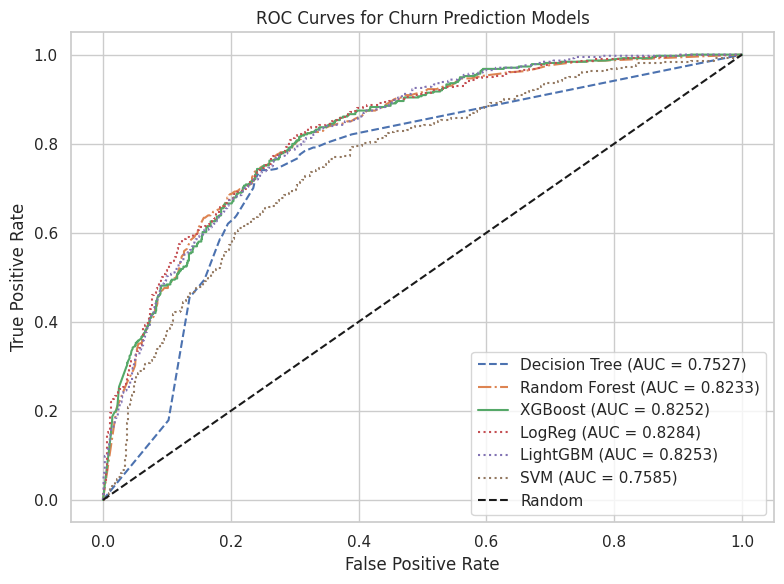

In [50]:
# 1. Probabilitas prediksi untuk masing-masing model
y_dt_proba = model_dt.predict_proba(x_test)[:, 1]
y_rf_proba = model_rf.predict_proba(x_test)[:, 1]
y_xgb_proba = model_xgb.predict_proba(x_test)[:, 1]
# --------- (
# Pengembangan dari Rizal
y_lr_proba = model_lr.predict_proba(x_test)[:, 1]
y_lgb_proba = model_lgb.predict_proba(x_test)[:, 1]
y_svm_proba = model_svm.predict_proba(x_test)[:, 1]
# --------- )

# 2. Hitung fpr dan tpr
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_dt_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_rf_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_xgb_proba)
# --------- (
# Pengembangan dari Rizal
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_lr_proba)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_lgb_proba)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_svm_proba)
# --------- )

# 3. Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_score(y_test, y_dt_proba):.4f})', linestyle='--')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_rf_proba):.4f})', linestyle='-.')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_xgb_proba):.4f})', linestyle='-')
# --------- (
# Pengembangan dari Rizal
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC = {roc_auc_score(y_test, y_lr_proba):.4f})', linestyle=':')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {roc_auc_score(y_test, y_lgb_proba):.4f})', linestyle=':')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_score(y_test, y_svm_proba):.4f})', linestyle=':')
# --------- )

# 4. Garis baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# 5. Label dan tampilan
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Churn Prediction Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

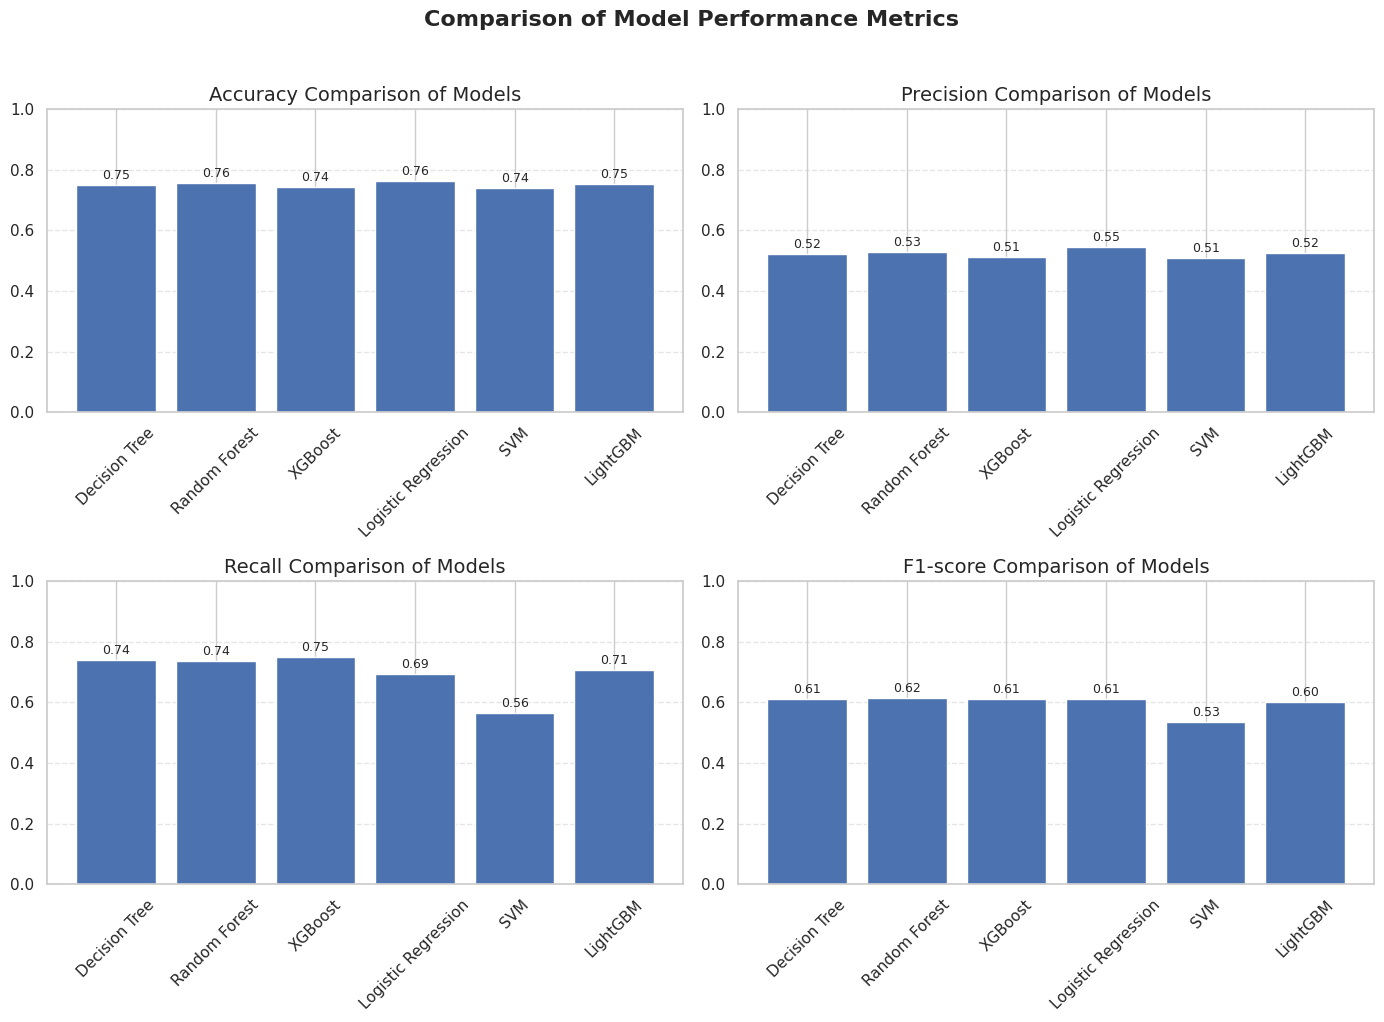

In [51]:
from sklearn.metrics import accuracy_score

model_scores = {}

# Decision Tree
yr_dt_pred = model_dt.predict(x_test)
report_dt = classification_report(y_test, yr_dt_pred, output_dict=True)
acc_dt = accuracy_score(y_test, yr_dt_pred)
model_scores['Decision Tree'] = {
    'Accuracy': acc_dt,
    'Precision': report_dt['1']['precision'],
    'Recall': report_dt['1']['recall'],
    'F1-score': report_dt['1']['f1-score']
}

# Random Forest
yr_rf_pred = model_rf.predict(x_test)
report_rf = classification_report(y_test, yr_rf_pred, output_dict=True)
acc_rf = accuracy_score(y_test, yr_rf_pred)
model_scores['Random Forest'] = {
    'Accuracy': acc_rf,
    'Precision': report_rf['1']['precision'],
    'Recall': report_rf['1']['recall'],
    'F1-score': report_rf['1']['f1-score']
}

# XGBoost
yr_xgb_pred = model_xgb.predict(x_test)
report_xgb = classification_report(y_test, yr_xgb_pred, output_dict=True)
acc_xgb = accuracy_score(y_test, yr_xgb_pred)
model_scores['XGBoost'] = {
    'Accuracy': acc_xgb,
    'Precision': report_xgb['1']['precision'],
    'Recall': report_xgb['1']['recall'],
    'F1-score': report_xgb['1']['f1-score']
}

# ------ (
# Pengembangan dari Rizal
# Tambahkan ke dict model_scores
report_lr = classification_report(y_test, yr_lr_pred, output_dict=True)
report_svm = classification_report(y_test, yr_svm_pred, output_dict=True)
report_lgb = classification_report(y_test, yr_lgb_pred, output_dict=True)


model_scores['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_test, yr_lr_pred),
    'Precision': report_lr['1']['precision'],
    'Recall': report_lr['1']['recall'],
    'F1-score': report_lr['1']['f1-score']
}

model_scores['SVM'] = {
    'Accuracy': accuracy_score(y_test, yr_svm_pred),
    'Precision': report_svm['1']['precision'],
    'Recall': report_svm['1']['recall'],
    'F1-score': report_svm['1']['f1-score']
}

model_scores['LightGBM'] = {
    'Accuracy': accuracy_score(y_test, yr_lgb_pred),
    'Precision': report_lgb['1']['precision'],
    'Recall': report_lgb['1']['recall'],
    'F1-score': report_lgb['1']['f1-score']
}


# ------ )

# Ubah dict ke DataFrame
df_scores = pd.DataFrame(model_scores).T

# Buat bar plot per metrik
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

plt.figure(figsize=(14, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.bar(df_scores.index, df_scores[metric])
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.title(f"{metric} Comparison of Models", fontsize=14)
    plt.ylim(0, 1)
    for idx, val in enumerate(df_scores[metric]):
        plt.text(idx, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    plt.xticks(rotation=45)
plt.suptitle("Comparison of Model Performance Metrics", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

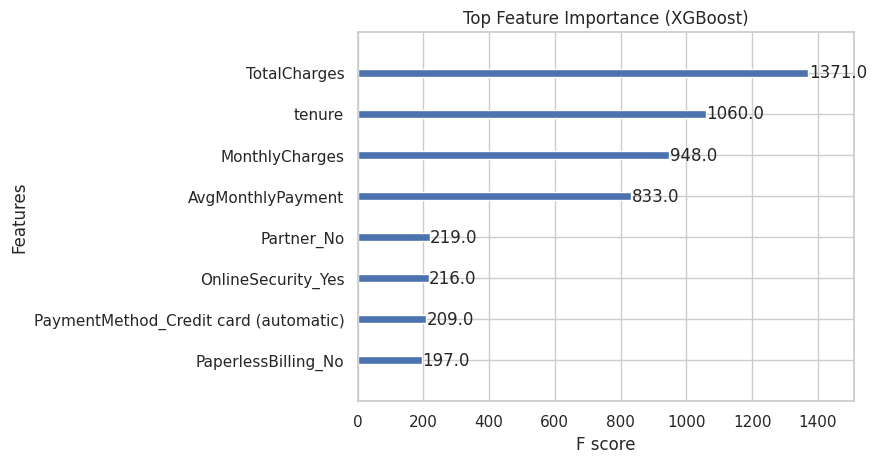

In [52]:
# Feature Importance Plot
import xgboost
xgboost.plot_importance(model_xgb, max_num_features=8) # Use xgboost.plot_importance instead of model_xgb.plot_importance
plt.title('Top Feature Importance (XGBoost)')
plt.show()

In [53]:
# --------- (
# Pengembangan dari Rizal
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model_xgb, x_resampled, y_resampled, cv=5)
print("Cross-Validation Mean Score (XGBoost):", np.mean(cv_scores))
# --------- )

Cross-Validation Mean Score (XGBoost): 0.9453672273594194


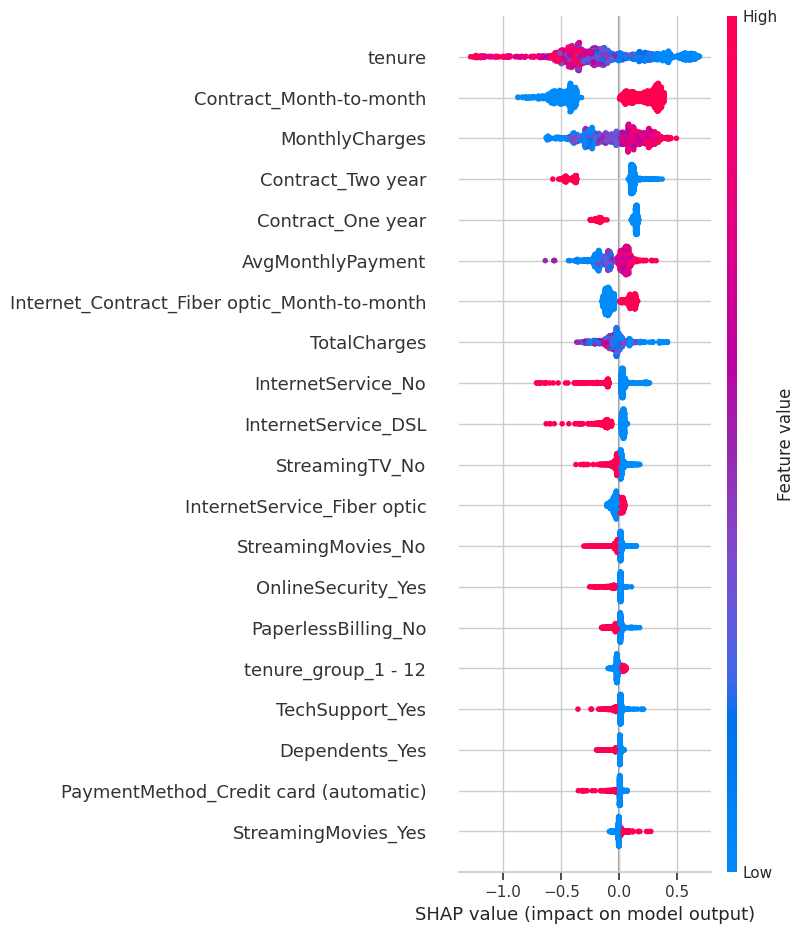

In [54]:
# SHAP Value Visualization (Opsional, Bonus)
import shap
explainer = shap.Explainer(model_xgb)
shap_values = explainer(x_test)

shap.summary_plot(shap_values, x_test, feature_names=x_test.columns)

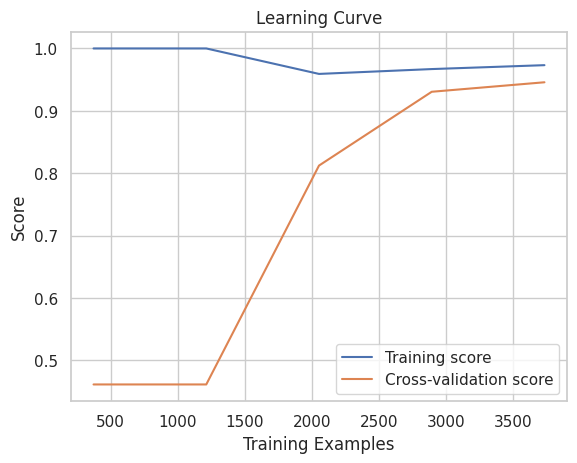

In [55]:
# Learning Curve (untuk tunjukkan performa model terhadap jumlah data)

from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(model_xgb, x_resampled, y_resampled, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

## Save Model

In [56]:
import joblib

Pada Perbandingan sebelumnya, kami memabandingkan 3 model untuk menulis paper yang berjudul "A Comparative Analysis of Machine Learning Algorithms for Predicting Customer Churn in the Telecommunication Industry " yaitu membandingkan :

o	DecisionTreeClassifier

o	RandomForestClassifier

o	XGBoostClassifier

Hailnya menunjukan model XGBoost paling baik. maka dari itu kami menyimpan model XGBoost


In [57]:
# Menentukan nama file ('model.sav') untuk menyimpan model yang telah dilatih
filename = 'xgboost_model.pkl'

joblib.dump(model_xgb, open(filename, 'wb'))
load_model = joblib.load(open(filename, 'rb'))
model_score_xgb = load_model.score(x_test, y_test)

# Menampilkan skor evaluasi model XGBoost pada data uji
model_score_xgb

0.7448471926083866

# Data Testing




In [58]:
# Data testing (input baru)
input_data = {
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'PhoneService': 'No',
    'MultipleLines': 'No phone service',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85,
    'TotalCharges': 29.85,
    'tenure_group': '1 - 12'  # Add tenure_group
}

# Konversi dictionary ke DataFrame
input_df = pd.DataFrame([input_data])

# Load model XGBoost yang sudah dilatih
filename = 'xgboost_model.pkl'
model_xgb_smote = joblib.load(open(filename, 'rb'))

# --- Apply one-hot encoding ---
# Get all categorical features from the input data
categorical_features = input_df.select_dtypes(include=['object']).columns

# Create a DataFrame with one-hot encoded features
encoded_features = pd.get_dummies(input_df[categorical_features])

# Concatenate encoded features with numerical features
input_df = pd.concat([input_df, encoded_features], axis=1)

# Remove original categorical features
input_df = input_df.drop(columns=categorical_features)

# --- Get missing columns and add them to input_df ---
# Get the feature names from the trained model
training_features = model_xgb.get_booster().feature_names

# Find missing columns
missing_cols = set(training_features) - set(input_df.columns)

# Add missing columns with value 0
for col in missing_cols:
    input_df[col] = 0

# Reorder the columns in input_df to match training_features
input_df = input_df[training_features]
# --- End of one-hot encoding ---

# Prediksi churn atau tidak churn
#prediction = model_xgb.predict(input_df)
#pred_prob = model_xgb.predict_proba(input_df)

# Perubahan Oleh Rizal
prediction = model_xgb_smote.predict(input_df)
pred_prob = model_xgb_smote.predict_proba(input_df)


# Output hasil prediksi
print(f"Prediction: {'Churn' if prediction[0] == 1 else 'No Churn'}")
print(f"Predicton Probability: {pred_prob}")

Prediction: Churn
Predicton Probability: [[0.19587022 0.8041298 ]]


In [59]:
from google.colab import files
files.download('xgboost_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Deployment

In [60]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.6 MB/s eta 0:00:00


In [61]:
import streamlit as st
import pandas as pd
import joblib

# Load model
model = joblib.load('xgboost_model.pkl')

st.title("📊 Prediksi Pelanggan Berhenti Berlangganan (Churn) Telco")

st.markdown("""
Aplikasi ini menggunakan model **XGBoost** untuk memprediksi apakah pelanggan akan **berhenti berlangganan (churn)** dari layanan Telco berdasarkan data langganan.
Silakan isi formulir di samping untuk melihat hasil prediksi. 👇
""")

st.sidebar.header("📝 Isi Data Pelanggan")

def user_input():
    SeniorCitizen = st.sidebar.radio(
        "Apakah pelanggan berusia 60 tahun ke atas?",
        ['Iya', 'Tidak']
    )
    Partner = st.sidebar.radio(
        "Memiliki pasangan (suami/istri)?",
        ['Iya', 'Tidak']
    )
    Dependents = st.sidebar.radio(
        "Memiliki tanggungan (anak/orang tua)?",
        ['Iya', 'Tidak']
    )
    PhoneService = st.sidebar.radio(
        "Menggunakan layanan telepon rumah?",
        ['Iya', 'Tidak'],
        help="Telepon rumah berarti layanan dasar panggilan suara dari penyedia Telco."
    )
    MultipleLines = st.sidebar.selectbox(
        "Layanan telepon ganda (lebih dari satu jalur)?",
        ['Tidak ada layanan telepon', 'Iya', 'Tidak']
    )
    InternetService = st.sidebar.selectbox(
        "Jenis layanan internet",
        ['DSL', 'Fiber optic', 'Tidak berlangganan internet']
    )
    OnlineSecurity = st.sidebar.selectbox(
        "Keamanan online",
        ['Iya', 'Tidak', 'Tidak ada layanan internet']
    )
    OnlineBackup = st.sidebar.selectbox(
        "Backup online",
        ['Iya', 'Tidak', 'Tidak ada layanan internet']
    )
    DeviceProtection = st.sidebar.selectbox(
        "Perlindungan perangkat",
        ['Iya', 'Tidak', 'Tidak ada layanan internet']
    )
    TechSupport = st.sidebar.selectbox(
        "Bantuan teknis",
        ['Iya', 'Tidak', 'Tidak ada layanan internet']
    )
    StreamingTV = st.sidebar.selectbox(
        "Layanan streaming TV",
        ['Iya', 'Tidak', 'Tidak ada layanan internet']
    )
    StreamingMovies = st.sidebar.selectbox(
        "Layanan streaming film",
        ['Iya', 'Tidak', 'Tidak ada layanan internet']
    )
    Contract = st.sidebar.selectbox(
        "Jenis kontrak berlangganan",
        ['1 bulan', '1 tahun', '2 tahun']
    )
    PaperlessBilling = st.sidebar.radio(
        "Menggunakan tagihan tanpa kertas?",
        ['Iya', 'Tidak']
    )
    PaymentMethod = st.sidebar.selectbox(
        "Metode pembayaran",
        ['Cek elektronik', 'Cek pos', 'Transfer otomatis (Bank)', 'Kartu kredit otomatis']
    )

    monthly_rp = st.sidebar.number_input("Biaya bulanan (Rp)", min_value=0.0, value=160000.0, step=1000.0)
    total_rp = st.sidebar.number_input("Total biaya selama ini (Rp)", min_value=0.0, value=1600000.0, step=1000.0)

    # Format tampilan mata uang
    st.sidebar.markdown(f"**➡️ Biaya Bulanan:** Rp {monthly_rp:,.0f}".replace(",", "."))
    st.sidebar.markdown(f"**➡️ Total Biaya:** Rp {total_rp:,.0f}".replace(",", "."))
    st.sidebar.caption("💡 Biaya dikonversi otomatis ke USD dengan kurs Rp16.000 per USD untuk keperluan model.")

    # Validasi sederhana
    if total_rp < monthly_rp:
        st.sidebar.warning("⚠️ Total biaya tidak boleh lebih kecil dari biaya bulanan.")

    # Konversi ke USD
    MonthlyCharges = monthly_rp / 16000
    TotalCharges = total_rp / 16000
    # Tambahkan baris berikut:
    st.sidebar.markdown(f"**➡️ Biaya Bulanan (USD):** ${MonthlyCharges:.2f}")
    st.sidebar.markdown(f"**➡️ Total Biaya (USD):** ${TotalCharges:.2f}")

    tenure_group = st.sidebar.selectbox("Lama berlangganan (bulan)", [
        '1 - 12', '13 - 24', '25 - 36', '37 - 48', '49 - 60', '61 - 72'
    ])

    data = {
        'SeniorCitizen': 1 if SeniorCitizen == 'Iya' else 0,
        'Partner': Partner,
        'Dependents': Dependents,
        'PhoneService': PhoneService,
        'MultipleLines': MultipleLines,
        'InternetService': InternetService,
        'OnlineSecurity': OnlineSecurity,
        'OnlineBackup': OnlineBackup,
        'DeviceProtection': DeviceProtection,
        'TechSupport': TechSupport,
        'StreamingTV': StreamingTV,
        'StreamingMovies': StreamingMovies,
        'Contract': 'Month-to-month' if Contract == '1 bulan' else ('One year' if Contract == '1 tahun' else 'Two year'),
        'PaperlessBilling': PaperlessBilling,
        'PaymentMethod': (
            'Electronic check' if PaymentMethod == 'Cek elektronik' else
            'Mailed check' if PaymentMethod == 'Cek pos' else
            'Bank transfer (automatic)' if PaymentMethod == 'Transfer otomatis (Bank)' else
            'Credit card (automatic)'
        ),
        'MonthlyCharges': MonthlyCharges,
        'TotalCharges': TotalCharges,
        'tenure_group': tenure_group
    }

    return pd.DataFrame([data])

# Ambil input
input_df = user_input()

# One-hot encoding
input_encoded = pd.get_dummies(input_df)
#input_data_for_predict = input_df

# Pastikan semua fitur sesuai dengan yang digunakan saat pelatihan model
model_features = model.get_booster().feature_names
for col in model_features:
    if col not in input_encoded.columns:
        input_encoded[col] = 0
input_encoded = input_encoded[model_features]

# Jika ingin pastikan kolom sama persis dengan yang model pakai:


# Tombol prediksi
if st.button("🔍 Prediksi Sekarang"):
    prediction = model.predict(input_encoded)
    proba = model.predict_proba(input_encoded)

    st.subheader("🔍 Hasil Prediksi")
    if prediction[0] == 1:
        st.error("🚫 Pelanggan **berisiko tinggi berhenti berlangganan** (*Churn*)")
        st.write("**Tingkat probabilitas pelanggan berhenti (churn):**", f"{proba[0][1]*100:.2f}%")

        st.markdown("### 💡 Rekomendasi:")
        st.markdown("""
        - Berikan promo atau diskon khusus untuk meningkatkan loyalitas.
        - Tawarkan kontrak jangka panjang dengan manfaat eksklusif.
        - Hubungi pelanggan untuk memahami keluhan atau kebutuhan mereka.
        """)

    else:
        st.success("✅ Pelanggan **kemungkinan besar tetap berlangganan**")
        st.write("**Tingkat probabilitas pelanggan berhenti (churn):**", f"{proba[0][1]*100:.2f}%")

        st.markdown("### 💡 Rekomendasi:")
        st.markdown("""
        - Pertahankan kualitas layanan yang sudah baik.
        - Kirimkan ucapan terima kasih atau hadiah loyalitas.
        - Lakukan survei berkala untuk menjaga kepuasan pelanggan.
        """)



2025-05-30 10:42:52.407 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 10:42:52.830 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-30 10:42:52.832 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 10:42:52.835 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 10:42:52.836 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 10:42:52.838 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 10:42:52.839 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-30 10:42:52.842 Thread 'MainThread': mi

In [62]:
import joblib
joblib.dump(model_xgb, 'xgboost_model.pkl')


['xgboost_model.pkl']